In [16]:
%run ml_load_data.ipynb
verbose_reference = False

Loading diabetes dataset


## Measuring True Privacy Leakage

In [17]:
def compute_feature_func(func, models):
    return np.array([func(model) for model in models])

In [18]:
def get_reference_attack(train_model, X_train, y_train, X_test, y_test, num_examples_to_attack = 50, num_ref_models = 10):
    
    # Collect some arbitrary target examples to attack.
    examples_to_attack = []

    # ...half from the training data.
    for index in X_train.index[:num_examples_to_attack // 2]:
        examples_to_attack.append((index, X_train.loc[index], y_train.loc[index], 1))

    # ...half from the test data.
    for index in X_test.index[:num_examples_to_attack // 2]:
        examples_to_attack.append((index, X_test.loc[index], y_test.loc[index], 0))

    result = []
    target_model = train_model(X_train, y_train)

    # Now run the re-training attacks!
    for index, x, y, is_member in tqdm(examples_to_attack):
        # First, train a bunch of models without the target example (if it is in fact part of the training data)
        out_models = []
        for seed in range(num_ref_models):
            ref_model = train_model(
                X_train.drop(index=[index], errors="ignore"),
                y_train.drop(index=[index], errors="ignore"),
                seed=seed
            )
            out_models.append(ref_model)

        # Compute the attack features.
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            preds_in = compute_feature_func(lambda model: model.predict_proba([x])[0], [target_model])
            preds_out = compute_feature_func(lambda model: model.predict_proba([x])[0], out_models)

        logit_in = logit_scale(y, preds_in)[0]
        logits_out = logit_scale(y, preds_out)

        # Next, we run a parametric test. We assume that "out" logits are Gaussian-distributed, 
        # so compute their mean and variance.
        logits_out_mean = np.mean(logits_out)
        logits_out_var = np.var(logits_out)

        # The parametric test is computing the probability that the "out" logits are less than "in" logit,
        # which means that we predict the target record as a member:
        # 
        #   Pr[logit_out <= logit_in], where logit_out ~ Normal(mean, var) with mean and var
        #   estimated from reference models.
        #
        # See https://arxiv.org/abs/2112.03570, Eq. (4)
        prob = stats.norm(logits_out_mean, logits_out_var).cdf(logit_in) 

        result.append(dict(
            target_index=index,
            is_member=is_member,
            prob=prob,
        ))
        
    return result

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.35s/it]


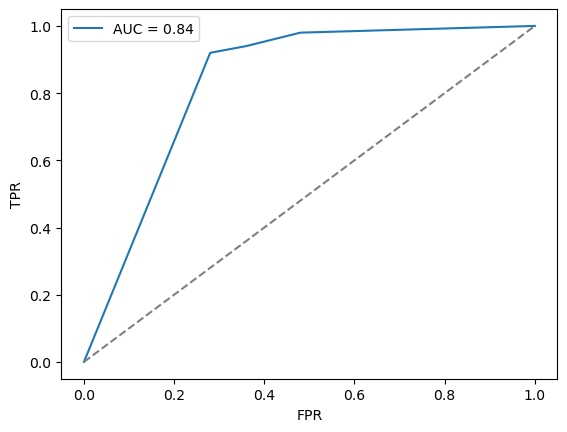

In [19]:
def plot_reference_attack(train_model, X_train, y_train, X_test, y_test, num_examples = 50):
    reference_attack = get_reference_attack(train_model, X_train, y_train, X_test, y_test, 50)
    fpr, tpr, _ = roc_curve(pd.DataFrame(reference_attack).is_member, pd.DataFrame(reference_attack).prob)
    roc_auc = auc(fpr, tpr)

    roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

    sns.lineplot(x='FPR', y='TPR', data=roc_df, label=f"AUC = {roc_auc:0.2f}", errorbar=None)
    sns.lineplot(x=[0, 1], y=[0, 1], color='grey', linestyle='--')
    

if verbose_reference:
    plot_reference_attack(train_model, X_train, y_train, X_test, y_test)